# Notebook para o PAN - Atribuição Autoral - 2018

This notebook describe a method for authorship attribution in a cross-domain.

We use instance-based aproach

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

#preprocessing and transformation
from sklearn.preprocessing import normalize, Normalizer, MaxAbsScaler, MinMaxScaler, LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier


from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.6.0-x86_64-i386-64bit
NumPy 1.14.2
SciPy 1.0.1
Scikit-Learn 0.19.1


### paths configuration

In [3]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [4]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [5]:
problems = readCollectionsOfProblems(inputDir);

In [6]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [7]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [8]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [9]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [11]:
pd.DataFrame(problems[0]['candidates']).groupby(1).count()

,0,2
1,,
candidate00001,7,7
candidate00002,7,7
candidate00003,7,7
candidate00004,7,7
candidate00005,7,7
candidate00006,7,7
candidate00007,7,7
candidate00008,7,7
candidate00009,7,7


In [12]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [13]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [14]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [15]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class ObfuscationTransformer(BaseEstimator):
    def __init__(self,re_from=r'(\b)(\w{0,2})\w+(\w{1,3})(\b)', re_to=r'\1\2XX\3\4', return_copy=True):
        self.re_from = re_from
        self.re_to = re_to

    def transform(self, X, y=None):
        X = np.array(X).copy();
        for i in range(len(X)):
            X[i] = re.sub(self.re_from,self.re_to, X[i])
        
        return X;

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [18]:
def runModel(problem, pipeline):
    t0 = time()
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']), end='  ')
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline.fit(train_docs, train_labels);
    #train_pred=pipeline.predict(train_docs);
    test_pred =pipeline.predict(test_docs);

    print("done in %0.3fs" % (time() - t0))
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v});
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(pathjoin(inputDir, problem['problem'], 'ground-truth.json'),answerFile)
    return {
                'problem'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                #"train_doc_size":       len(train_docs),
                #"train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                #"test_doc_size" :       len(test_docs),
                #"test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'f1'       : round(f1,3),
                'precision': round(precision,3),
                'recall'   : round(recall,3),
                'accuracy' : round(accuracy,3),
        };

In [19]:
pipelineCharacter = Pipeline([
    ('vect',   TfidfVectorizer(
            analyzer='char',
            min_df=0.05,
            max_df=1.0,
            ngram_range=(2,5),
            lowercase=False,
            norm='l2',
            sublinear_tf=True)),
    ('dense',  DenseTransformer()),
    ('scaler', MaxAbsScaler()),
    ('transf', PCA(0.999)),
    ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
])

resultCharacter = [];
for problem in problems:
    resultCharacter.append(runModel(problem, pipelineCharacter));
pd.DataFrame(resultCharacter)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

Problem: problem00001,  language: en,   done in 4.732s
Problem: problem00002,  language: en,   done in 1.236s
Problem: problem00003,  language: fr,   done in 3.992s
Problem: problem00004,  language: fr,   done in 1.255s
Problem: problem00005,  language: it,   done in 4.798s
Problem: problem00006,  language: it,   done in 1.905s
Problem: problem00007,  language: pl,   done in 6.315s
Problem: problem00008,  language: pl,   done in 1.618s
Problem: problem00009,  language: sp,   done in 5.760s
Problem: problem00010,  language: sp,   done in 2.174s


,problem,language,AuthorCount,f1,accuracy,precision,recall
0,problem00001,en,20,0.609,0.648,0.582,0.748
1,problem00002,en,5,0.535,0.476,0.567,0.633
2,problem00003,fr,20,0.681,0.735,0.664,0.742
3,problem00004,fr,5,0.719,0.667,0.766,0.753
4,problem00005,it,20,0.597,0.688,0.616,0.709
5,problem00006,it,5,0.623,0.783,0.630,0.668
6,problem00007,pl,20,0.470,0.495,0.473,0.571
7,problem00008,pl,5,0.948,0.933,0.933,0.978
8,problem00009,sp,20,0.774,0.786,0.776,0.835
9,problem00010,sp,5,0.778,0.844,0.783,0.785


In [20]:
pipelineObfuscator = Pipeline([
        ('obs',ObfuscationTransformer(re_from=r'\w',re_to='x')),
        ('vect',   TfidfVectorizer(
                analyzer='char',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(2,5),
                lowercase=False,
                norm='l2',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])

resultObfuscator = [];
for problem in problems:
    resultObfuscator.append(runModel(problem, pipelineObfuscator));
pd.DataFrame(resultObfuscator)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

Problem: problem00001,  language: en,   done in 3.310s
Problem: problem00002,  language: en,   done in 0.750s
Problem: problem00003,  language: fr,   done in 2.700s
Problem: problem00004,  language: fr,   done in 0.848s
Problem: problem00005,  language: it,   done in 3.217s
Problem: problem00006,  language: it,   done in 1.210s
Problem: problem00007,  language: pl,   done in 3.939s
Problem: problem00008,  language: pl,   done in 0.899s
Problem: problem00009,  language: sp,   done in 3.777s
Problem: problem00010,  language: sp,   done in 1.483s


,problem,language,AuthorCount,f1,accuracy,precision,recall
0,problem00001,en,20,0.479,0.533,0.481,0.692
1,problem00002,en,5,0.333,0.286,0.270,0.520
2,problem00003,fr,20,0.568,0.571,0.564,0.643
3,problem00004,fr,5,0.586,0.571,0.647,0.727
4,problem00005,it,20,0.491,0.637,0.460,0.604
5,problem00006,it,5,0.595,0.804,0.594,0.691
6,problem00007,pl,20,0.496,0.485,0.544,0.543
7,problem00008,pl,5,0.570,0.667,0.573,0.711
8,problem00009,sp,20,0.589,0.624,0.563,0.681
9,problem00010,sp,5,0.802,0.828,0.804,0.810


In [21]:
pipelineWord = Pipeline([
        ('vect',   TfidfVectorizer(
                analyzer='word',
                min_df=0.05,
                max_df=1.0,
                ngram_range=(1,3),
                lowercase=True,
                norm='l2',
                sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')),
    ]);

resultWord = [];
for problem in problems:
    resultWord.append(runModel(problem, pipelineWord));
pd.DataFrame(resultWord)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

Problem: problem00001,  language: en,   done in 1.462s
Problem: problem00002,  language: en,   done in 0.395s
Problem: problem00003,  language: fr,   done in 1.293s
Problem: problem00004,  language: fr,   done in 0.371s
Problem: problem00005,  language: it,   done in 1.432s
Problem: problem00006,  language: it,   done in 0.456s
Problem: problem00007,  language: pl,   done in 1.612s
Problem: problem00008,  language: pl,   done in 0.390s
Problem: problem00009,  language: sp,   done in 1.706s
Problem: problem00010,  language: sp,   done in 0.619s


,problem,language,AuthorCount,f1,accuracy,precision,recall
0,problem00001,en,20,0.444,0.562,0.439,0.633
1,problem00002,en,5,0.577,0.762,0.547,0.650
2,problem00003,fr,20,0.418,0.510,0.447,0.469
3,problem00004,fr,5,0.572,0.619,0.647,0.687
4,problem00005,it,20,0.497,0.525,0.504,0.680
5,problem00006,it,5,0.520,0.674,0.536,0.607
6,problem00007,pl,20,0.475,0.505,0.458,0.603
7,problem00008,pl,5,0.922,0.933,0.900,0.978
8,problem00009,sp,20,0.616,0.624,0.607,0.683
9,problem00010,sp,5,0.588,0.703,0.600,0.610


In [22]:
def runEnsemble(problem, pipelines):
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']),end=' ')
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    t0 = time()
    for p in pipelines:
        p.fit(train_docs, train_labels)

    xtrain_mix = np.hstack([p.predict_proba(train_docs) for p in pipelines])
    xtest_mix  = np.hstack([p.predict_proba(test_docs) for p in pipelines])

    clfFinal = LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg');
    clfFinal.fit(xtrain_mix, train_labels);
    #train_pred=clfFinal.predict(xtrain_mix);
    test_pred =clfFinal.predict(xtest_mix);
    print("done in %0.3fs" % (time() - t0))
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(pathjoin(inputDir, problem['problem'], 'ground-truth.json'),answerFile)
    return {
                'problem'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                #"train_doc_size":       len(train_docs),
                #"train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                #"test_doc_size" :       len(test_docs),
                #"test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'f1'       : round(f1,3),
                'precision': round(precision,3),
                'recall'   : round(recall,3),
                'accuracy' : round(accuracy,3),
        };

In [23]:
pipelineCO = [pipelineCharacter, pipelineObfuscator]

resultCO = [];
for problem in problems:
    resultCO.append(runEnsemble(problem, pipelineCO));
pd.DataFrame(resultCO)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

Problem: problem00001,  language: en,  done in 12.341s
Problem: problem00002,  language: en,  done in 3.064s
Problem: problem00003,  language: fr,  done in 11.161s
Problem: problem00004,  language: fr,  done in 3.392s
Problem: problem00005,  language: it,  done in 13.008s
Problem: problem00006,  language: it,  done in 4.327s
Problem: problem00007,  language: pl,  done in 16.037s
Problem: problem00008,  language: pl,  done in 3.587s
Problem: problem00009,  language: sp,  done in 14.357s
Problem: problem00010,  language: sp,  done in 4.917s


,problem,language,AuthorCount,f1,accuracy,precision,recall
0,problem00001,en,20,0.499,0.571,0.484,0.709
1,problem00002,en,5,0.467,0.381,0.410,0.600
2,problem00003,fr,20,0.730,0.694,0.733,0.792
3,problem00004,fr,5,0.764,0.667,0.795,0.830
4,problem00005,it,20,0.526,0.662,0.499,0.630
5,problem00006,it,5,0.622,0.826,0.612,0.703
6,problem00007,pl,20,0.558,0.563,0.589,0.580
7,problem00008,pl,5,0.600,0.733,0.583,0.733
8,problem00009,sp,20,0.647,0.718,0.645,0.765
9,problem00010,sp,5,0.877,0.906,0.892,0.874


In [24]:
pipelineCP = [pipelineCharacter, pipelineWord]

resultCP = [];
for problem in problems:
    resultCP.append(runEnsemble(problem, pipelineCP));
pd.DataFrame(resultCP)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

Problem: problem00001,  language: en,  done in 9.568s
Problem: problem00002,  language: en,  done in 2.458s
Problem: problem00003,  language: fr,  done in 8.211s
Problem: problem00004,  language: fr,  done in 2.324s
Problem: problem00005,  language: it,  done in 9.102s
Problem: problem00006,  language: it,  done in 3.071s
Problem: problem00007,  language: pl,  done in 11.127s
Problem: problem00008,  language: pl,  done in 2.706s
Problem: problem00009,  language: sp,  done in 10.048s
Problem: problem00010,  language: sp,  done in 3.567s


,problem,language,AuthorCount,f1,accuracy,precision,recall
0,problem00001,en,20,0.625,0.667,0.623,0.755
1,problem00002,en,5,0.673,0.714,0.675,0.717
2,problem00003,fr,20,0.605,0.714,0.610,0.680
3,problem00004,fr,5,0.719,0.667,0.766,0.753
4,problem00005,it,20,0.575,0.662,0.553,0.726
5,problem00006,it,5,0.609,0.804,0.606,0.687
6,problem00007,pl,20,0.528,0.544,0.530,0.636
7,problem00008,pl,5,1.000,1.000,1.000,1.000
8,problem00009,sp,20,0.714,0.726,0.729,0.795
9,problem00010,sp,5,0.735,0.828,0.747,0.752


In [25]:
pipelineOP = [pipelineObfuscator, pipelineWord]

resultOP = [];
for problem in problems:
    resultOP.append(runEnsemble(problem, pipelineOP));
pd.DataFrame(resultOP)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

Problem: problem00001,  language: en,  done in 7.033s
Problem: problem00002,  language: en,  done in 1.690s
Problem: problem00003,  language: fr,  done in 6.613s
Problem: problem00004,  language: fr,  done in 1.836s
Problem: problem00005,  language: it,  done in 7.414s
Problem: problem00006,  language: it,  done in 2.374s
Problem: problem00007,  language: pl,  done in 8.745s
Problem: problem00008,  language: pl,  done in 2.101s
Problem: problem00009,  language: sp,  done in 9.554s
Problem: problem00010,  language: sp,  done in 3.184s


,problem,language,AuthorCount,f1,accuracy,precision,recall
0,problem00001,en,20,0.498,0.571,0.491,0.702
1,problem00002,en,5,0.425,0.333,0.383,0.560
2,problem00003,fr,20,0.668,0.653,0.671,0.732
3,problem00004,fr,5,0.798,0.714,0.820,0.880
4,problem00005,it,20,0.487,0.650,0.441,0.620
5,problem00006,it,5,0.650,0.826,0.636,0.703
6,problem00007,pl,20,0.533,0.515,0.565,0.558
7,problem00008,pl,5,0.635,0.800,0.600,0.756
8,problem00009,sp,20,0.660,0.718,0.664,0.765
9,problem00010,sp,5,0.778,0.844,0.831,0.782


In [26]:
pipelineCOP = [pipelineCharacter,pipelineObfuscator, pipelineWord]

resultCOP = [];
for problem in problems:
    resultCOP.append(runEnsemble(problem, pipelineCOP));
pd.DataFrame(resultCOP)[['problem','language','AuthorCount','f1','accuracy','precision','recall']]

Problem: problem00001,  language: en,  done in 16.466s
Problem: problem00002,  language: en,  done in 3.783s
Problem: problem00003,  language: fr,  done in 14.842s
Problem: problem00004,  language: fr,  done in 4.123s
Problem: problem00005,  language: it,  done in 17.021s
Problem: problem00006,  language: it,  done in 5.384s
Problem: problem00007,  language: pl,  done in 19.695s
Problem: problem00008,  language: pl,  done in 4.625s
Problem: problem00009,  language: sp,  done in 18.733s
Problem: problem00010,  language: sp,  done in 6.441s


,problem,language,AuthorCount,f1,accuracy,precision,recall
0,problem00001,en,20,0.527,0.610,0.505,0.734
1,problem00002,en,5,0.462,0.381,0.417,0.600
2,problem00003,fr,20,0.776,0.755,0.777,0.818
3,problem00004,fr,5,0.820,0.762,0.820,0.870
4,problem00005,it,20,0.576,0.675,0.551,0.680
5,problem00006,it,5,0.663,0.848,0.652,0.715
6,problem00007,pl,20,0.554,0.573,0.578,0.586
7,problem00008,pl,5,0.922,0.933,0.900,0.978
8,problem00009,sp,20,0.701,0.769,0.695,0.793
9,problem00010,sp,5,0.830,0.891,0.845,0.841


In [28]:
pd.set_option('precision', 3)
df = pd.DataFrame({
    'Problema':[c['problem'][-2:] for c in resultCharacter],
    u'Língua' :[c['language'].upper() for c in resultCharacter],
    u'Autores' :[c['AuthorCount'] for c in resultCharacter],
    'C':[c['f1'] for c in resultCharacter],
    'O':[c['f1'] for c in resultObfuscator],
    'P':[c['f1'] for c in resultWord],
    'CP':[c['f1'] for c in resultCP],
    'CO':[c['f1'] for c in resultCO],
    'OP':[c['f1'] for c in resultOP],
    'COP':[c['f1'] for c in resultCOP],
    'PAN':[0.514,0.626,0.631,0.747,0.529,0.614,0.455,0.703,0.709,0.593],
    u'Comitê':[0.625, 0.673, 0.776, 0.82, 0.578, 0.663, 0.554, 0.922, 0.701, 0.83]
})[['Problema',u'Língua',u'Autores','C','O','P','CP','CO','OP','COP','PAN',u'Comitê']]


cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm, axis=1,subset=['C','O','P','CP','CO','OP','COP'])
s

,Problema,Língua,Autores,C,O,P,CP,CO,OP,COP,PAN,Comitê
0,01,EN,20,0.609,0.479,0.444,0.625,0.499,0.498,0.527,0.514,0.625
1,02,EN,5,0.535,0.333,0.577,0.673,0.467,0.425,0.462,0.626,0.673
2,03,FR,20,0.681,0.568,0.418,0.605,0.73,0.668,0.776,0.631,0.776
3,04,FR,5,0.719,0.586,0.572,0.719,0.764,0.798,0.82,0.747,0.82
4,05,IT,20,0.597,0.491,0.497,0.575,0.526,0.487,0.576,0.529,0.578
5,06,IT,5,0.623,0.595,0.52,0.609,0.622,0.65,0.663,0.614,0.663
6,07,PL,20,0.47,0.496,0.475,0.528,0.558,0.533,0.554,0.455,0.554
7,08,PL,5,0.948,0.57,0.922,1,0.6,0.635,0.922,0.703,0.922
8,09,SP,20,0.774,0.589,0.616,0.714,0.647,0.66,0.701,0.709,0.701
9,10,SP,5,0.778,0.802,0.588,0.735,0.877,0.778,0.83,0.593,0.83


In [29]:
df.mean(numeric_only=True).to_frame().T

,Autores,C,O,P,CP,CO,OP,COP,PAN,Comitê
0,12.5,0.673,0.551,0.563,0.678,0.629,0.613,0.683,0.612,0.714


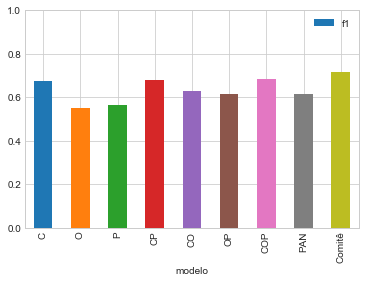

In [220]:
means = df.mean(numeric_only=True).to_frame().reset_index()
means.columns=['modelo','f1']
means[means.modelo !='Autores'].plot.bar(x='modelo',y='f1', ylim=(0,1));

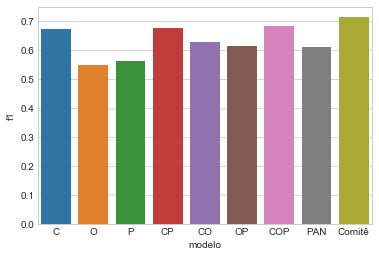

In [221]:
sns.set_style("whitegrid")
sns.barplot(data=means[means.modelo !='Autores'],x='modelo',y='f1');

In [228]:
print(df[['Problema',u'Língua',u'Autores','PAN','C','O','P',u'Comitê']].to_latex(index=False).replace(' ',''))

\begin{tabular}{llrrrrrr}
\toprule
Problema&Língua&Autores&PAN&C&O&P&Comitê\\
\midrule
01&EN&20&0.514&0.609&0.479&0.444&0.625\\
02&EN&5&0.626&0.535&0.333&0.577&0.673\\
03&FR&20&0.631&0.681&0.568&0.418&0.776\\
04&FR&5&0.747&0.719&0.586&0.572&0.820\\
05&IT&20&0.529&0.597&0.491&0.497&0.578\\
06&IT&5&0.614&0.623&0.595&0.520&0.663\\
07&PL&20&0.455&0.470&0.496&0.475&0.554\\
08&PL&5&0.703&0.948&0.570&0.922&0.922\\
09&SP&20&0.709&0.774&0.589&0.616&0.701\\
10&SP&5&0.593&0.778&0.802&0.588&0.830\\
\bottomrule
\end{tabular}



In [234]:
print((df[['PAN','C','O','P',u'Comitê']].mean().to_frame().T).to_latex(index=False).replace(' ',''))

\begin{tabular}{rrrrr}
\toprule
PAN&C&O&P&Comitê\\
\midrule
0.612&0.673&0.551&0.563&0.714\\
\bottomrule
\end{tabular}



In [34]:
print(df[['Problema',u'Língua',u'Autores','PAN','OP','CO','CP',u'Comitê']].to_latex(index=False).replace('0.','0,'))

\begin{tabular}{llrrrrrr}
\toprule
Problema & Língua &  Autores &    PAN &     OP &     CO &     CP &  Comitê \\
\midrule
      01 &     EN &       20 &  0,514 &  0,498 &  0,499 &  0,625 &   0,625 \\
      02 &     EN &        5 &  0,626 &  0,425 &  0,467 &  0,673 &   0,673 \\
      03 &     FR &       20 &  0,631 &  0,668 &  0,730 &  0,605 &   0,776 \\
      04 &     FR &        5 &  0,747 &  0,798 &  0,764 &  0,719 &   0,820 \\
      05 &     IT &       20 &  0,529 &  0,487 &  0,526 &  0,575 &   0,578 \\
      06 &     IT &        5 &  0,614 &  0,650 &  0,622 &  0,609 &   0,663 \\
      07 &     PL &       20 &  0,455 &  0,533 &  0,558 &  0,528 &   0,554 \\
      08 &     PL &        5 &  0,703 &  0,635 &  0,600 &  1.000 &   0,922 \\
      09 &     SP &       20 &  0,709 &  0,660 &  0,647 &  0,714 &   0,701 \\
      10 &     SP &        5 &  0,593 &  0,778 &  0,877 &  0,735 &   0,830 \\
\bottomrule
\end{tabular}



In [33]:
print(df[['PAN','OP','CP',u'Comitê']].mean().to_frame().T.to_latex(index=False).replace('0.','0,'))

\begin{tabular}{rrrr}
\toprule
   PAN &     OP &     CP &  Comitê \\
\midrule
 0,612 &  0,613 &  0,678 &   0,714 \\
\bottomrule
\end{tabular}



In [135]:
means

,modelo,f1
0,Autores,12.500
1,C,0.673
2,O,0.551
3,P,0.563
4,CP,0.678
5,CO,0.629
6,OP,0.613
7,COP,0.683
8,PAN,0.612
9,Comitê,0.714


In [ ]:
print(df[['Problema',u'Língua',u'Autores','PAN','C','O','P','COP',u'Comitê']].to_latex(index=False).replace('0.','0,'))

Analisando a importancia

In [552]:
maxabs_scale([cc-5 for cc in range(10)])

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8])

In [606]:
from sklearn.feature_selection import SelectFpr

In [662]:
def featureImportanceList(pipeline, problem):
    train_docs, train_labels, _   = zip(*problem['candidates'])
    X = pipeline.fit_transform(train_docs, train_labels);
    features =np.array(pipeline.named_steps.vect.get_feature_names())
    clf = LogisticRegression(random_state=0,multi_class='multinomial', solver='saga')
    clf.fit(X, train_labels);
    
    table = {}
    for a, author in zip(clf.coef_, clf.classes_):
        aa = maxabs_scale(a);
        aa = np.argsort(-aa)[:20];#reverse sort
        table[author] = [b.replace(' ','_') for b in features[aa]];
        #table[author+'_'] = a[aa]
    return table

In [663]:
problem = problems[1];

p = Pipeline([
    ('vect', pipelineCharacter.named_steps['vect']),
    ('dense',  DenseTransformer()),
    ('scaler', StandardScaler()),
    ('selector',SelectFpr())
    
])
charTable = featureImportanceList(p, problem)

In [672]:
print(pd.DataFrame(charTable).head(20).to_latex(index=False).replace('    ',' '))

\begin{tabular}{lllll}
\toprule
candidate00001 & candidate00002 & candidate00003 & candidate00004 & candidate00005 \\
\midrule
   \_as\_l &     \_Sti &     \_sub &     \_joi &    \_day, \\
   \_' &    \_"Can &     \_suc &   \_gh &     \_dev \\
   \_prec &     \_"Ca &    \_I\_fi &   \_er &    \_dete \\
    \_I'd &     \_"Be &    \_succ &    \_glow &    \_plac \\
   \_"Are &     \_but &    \_subs &   \_Is &     \_mut \\
     \_Re &    \_but\_ &     \_I\_f &     \_sta &    \_must \\
   \_smel &    \_Ofte &   \_"T &     \_gor &     \_Dro \\
   \_leak &    \_posi &     \_a\_t &    \_sorr &    \_day\_ \\
   \_is\_s &     \_For &     \_"St &    \_eat\_ &    \_she\_ \\
    \_spu &   \_Ri &    \_a\_sw &    \_If\_t &     \_chi \\
   \_I\_se &    \_Stil &    \_a\_th &   \_or &    \_not. \\
   \_a\_sh &    \_reco &    \_"I'm &   \_sc &    \_horr \\
   \_bite &    \_rece &   \_Za &    \_of\_n &    \_grou \\
   \_clea &    \_K &    \_by\_h &    \_of\_m &    \_char \\
    \_elb &     \_lis &     \_do

In [665]:
pd.DataFrame(charTable)

,candidate00001,candidate00002,candidate00003,candidate00004,candidate00005
0,_as_l,_Sti,_sub,_joi,"_day,"
1,_',"_""Can",_suc,_gh,_dev
2,_prec,"_""Ca",_I_fi,_er,_dete
3,_I'd,"_""Be",_succ,_glow,_plac
4,"_""Are",_but,_subs,_Is,_mut
5,_Re,_but_,_I_f,_sta,_must
6,_smel,_Ofte,"_""T",_gor,_Dro
7,_leak,_posi,_a_t,_sorr,_day_
8,_is_s,_For,"_""St",_eat_,_she_
9,_spu,_Ri,_a_sw,_If_t,_chi


In [673]:
problem = problems[1];

p = Pipeline([
    ('obfusc',ObfuscationTransformer(re_from=r'\w',re_to='*')),
    ('vect', pipelineObfuscator.named_steps['vect']),
    ('dense',  DenseTransformer()),
    ('scaler', StandardScaler()),
    ('selector',SelectFpr())
])
charObf = featureImportanceList(p, problem)

In [674]:
print(pd.DataFrame(charObf).head(20).to_latex(index=False).replace('    ',' '))

\begin{tabular}{lllll}
\toprule
candidate00001 & candidate00002 & candidate00003 & candidate00004 & candidate00005 \\
\midrule
    *\_É* &    \_**\_- &   "*' &     *\_\textasciitilde\_ &    *\_–\_* \\
    \_**- &    \_**\_( &    "*\_** &   *\_\textasciitilde &    '*,\_* \\
   *' &    \_**\_* &    !),\_* &    *\_.\_* &   "\_\textasciitilde \\
    **). &    *! &    **\_*í &     '*** &   *\_– \\
   **),\_ &    \_**\_' &    \_**\_É &    '**** &     *\_–\_ \\
   *\_-\_* &     *!\_* &    **\_*' &    "\_**' &   '*. \\
    *\_-\_ &    *\_“** &    **\_** &    \_É*** &   \_“* \\
    \_'** &   \_\textasciitilde\_ &    **\_*’ &     \_“*’ &    \_- \\
     !), &     \_\textasciitilde\_* &     \_**! &    \_**.. &   \_-\_ \\
   \_'*** &     \_“*' &    *!\_*\_ &    *\_**é &    \_"*** \\
   "* &    \_\textasciitilde &   *!! &    *\_**? &    \_"**. \\
     "*\_ &    \_“*\_* &    *!\_*. &    '* &    \_"**, \\
   '*.\_* &     *'*. &    *!\_** &    '\_*** &   *'\_ \\
   ', &   ).\_ &    (* &    *\_**’ &    

In [668]:
pd.DataFrame(charObf)

,candidate00001,candidate00002,candidate00003,candidate00004,candidate00005
0,*_É*,_**_-,"""*'",*_~_,*_–_*
1,_**-,_**_(,"""*_**",*_~,"'*,_*"
2,*',_**_*,"!),_*",*_._*,"""_~"
3,**).,*!,**_*í,'***,*_–
4,"**),_",_**_',_**_É,'****,*_–_
5,*_-_*,*!_*,**_*',"""_**'",'*.
6,*_-_,*_“**,**_**,_É***,_“*
7,_'**,_~_,**_*’,_“*’,_-
8,"!),",_~_*,_**!,_**..,_-_
9,_'***,_“*',*!_*_,*_**é,"_""***"


In [679]:
problem = problems[1];

p = Pipeline([
    ('vect', pipelineWord.named_steps['vect']),
    ('dense',  DenseTransformer()),
    ('scaler', StandardScaler()),
    ('selector',SelectFpr())
])
wordTable = featureImportanceList(p, problem)

In [680]:
print(pd.DataFrame(wordTable).head(20).to_latex(index=False).replace('    ',' '))

\begin{tabular}{lllll}
\toprule
  candidate00001 & candidate00002 & candidate00003 & candidate00004 &  candidate00005 \\
\midrule
   about\_what &    against\_his &   an\_odd &    although &  and\_pulled\_him \\
 and\_practically &  and\_it\_was &    and\_then\_he &   an\_eye &  and\_pulling \\
    any\_of &   and\_so &   acknowledged &    and\_said &   across\_his \\
  any\_more &    and\_already &  and\_he\_had &   and\_takes &   across\_the \\
   and\_nearly &   and\_steve &    are\_your &    and\_just &   and\_all \\
   and\_pulled &     and\_say &    again\_to &     ancient &  against\_her \\
     agree &   accent &    and\_tell &   amount\_of &     among \\
  all\_tony &     and\_wet &   and\_forth &   always &   about\_what\_to \\
     ah &  apparently &    are\_just &    and\_grinned &    acting \\
  and\_wet\_and &    after &   and\_grabbing &   about\_the &  about\_their \\
    an\_arm &      act &    and\_give &  against\_the\_wall &  and\_tony \\
 and\_her\_eyes &    and\_s

In [681]:
pd.DataFrame(wordTable)

,candidate00001,candidate00002,candidate00003,candidate00004,candidate00005
0,about_what,against_his,an_odd,although,and_pulled_him
1,and_practically,and_it_was,and_then_he,an_eye,and_pulling
2,any_of,and_so,acknowledged,and_said,across_his
3,any_more,and_already,and_he_had,and_takes,across_the
4,and_nearly,and_steve,are_your,and_just,and_all
5,and_pulled,and_say,again_to,ancient,against_her
6,agree,accent,and_tell,amount_of,among
7,all_tony,and_wet,and_forth,always,about_what_to
8,ah,apparently,are_just,and_grinned,acting
9,and_wet_and,after,and_grabbing,about_the,about_their
